In [1]:
import numpy as np
from skimage.feature import local_binary_pattern
from image_preprocessor import Preprocessor

# Extracting LBP-TOP features from the data

In [2]:
# LBP parameters
radius = 1  # Radius of LBP
n_points = 8 * radius  # Number of points in LBP

# Define the path to the dataset
path = 'C:/Users/venla/Documents/Affective_computing/Project/OriginalImg/NI/Dark'

# Define the emotion labels and their corresponding numeric values
emotion_labels = {
    'Anger': 0,
    'Disgust': 1,
    'Fear': 2,
    'Happiness': 3,
    'Sadness': 4,
    'Surprise': 5
}

## 1. Reading the dataset

In [3]:
# Initializing the Preprocessor
preprocessor = Preprocessor()

#Reading the dataset
videos, labels = preprocessor.load_dataset(dataset_path=path, emotion_labels=emotion_labels)

## 2. Preprocessing the images

In [4]:
preprocessor.load_landmarks_from_csv("mean.csv")

This part takes a loooooong time, don't run again but use the saved preprocessed images:

In [18]:
## DON'T RUN THIS AGAIN

# processed_videos = []
# for video in videos:
#     processed_video = []
#     for frame in video:
#         processed_frame = preprocessor.preprocess(frame)
#         processed_video.append(processed_frame)
#     processed_videos.append(processed_video)

In [19]:
# Convert image data and labels to NumPy arrays
# videos = np.array(processed_videos, dtype = object)
# labels = np.array(labels)

In [21]:
# np.save('preprocessed_videos_array.npy', videos)
# np.save('labels.npy', labels)

## CAN RUN FROM HERE ON

Loading the preprocessed images from the saved numpy arrays:

In [8]:
videos = np.load('preprocessed_videos_array.npy', allow_pickle=True)
labels = np.load('labels.npy', allow_pickle=True)

Plotting an example of a preprocessed image

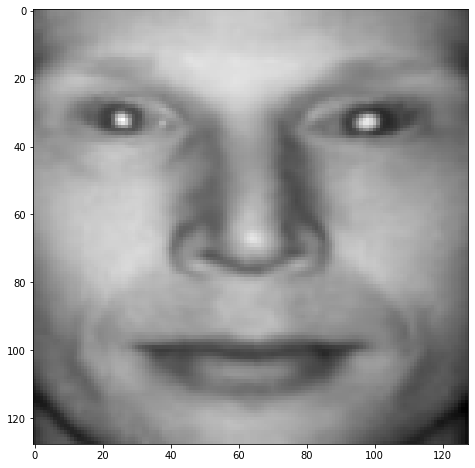

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(videos[59][2], "gray")
plt.show()

## 3. Computing the LBP-TOP feature vectors for each video in the dataset

In [9]:
# Function to compute LBP for a given image
def compute_lbp(image, radius, n_points):
    return local_binary_pattern(image, n_points, radius, method='nri_uniform')


In [10]:
# Function to compute LBP top features for an array of videos
def compute_lbp_top(videos, n_bins):
    
    lbp_top_vectors = []
    for video in videos:
        video = np.array(video)
        # 1. LBP on XY plane (regular LBP on each frame)
        num_frames, height, width = video.shape
        xy_lbp_histograms = []

        for frame in video:
            lbp = compute_lbp(frame, radius, n_points)
            hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
            hist = hist.astype(float) / hist.sum()
            xy_lbp_histograms.append(hist)

        xy_lbp_histograms = np.array(xy_lbp_histograms)
        xy_lbp_histogram = np.mean(xy_lbp_histograms, axis=0)  # Average histogram over all frames

        # 2. LBP on XT plane (variation along x-axis over time for all rows)
        xt_lbp_histograms = []
        for row in range(height):  # Iterate over each row
            xt_planes = video[:, row, :]  # Get XT plane for this row
            xt_lbp = compute_lbp(xt_planes, radius, n_points)
            hist, _ = np.histogram(xt_lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
            hist = hist.astype(float) / hist.sum()
            xt_lbp_histograms.append(hist)

        xt_lbp_histograms = np.array(xt_lbp_histograms)
        xt_lbp_histogram = np.mean(xt_lbp_histograms, axis=0)  # Average histogram over all rows

        # 3. LBP on YT plane (variation along y-axis over time for all columns)
        yt_lbp_histograms = []
        for col in range(width):  # Iterate over each column
            yt_planes = video[:, :, col]  # Get YT plane for this column
            yt_lbp = compute_lbp(yt_planes, radius, n_points)
            hist, _ = np.histogram(yt_lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
            hist = hist.astype(float) / hist.sum()
            yt_lbp_histograms.append(hist)

        yt_lbp_histograms = np.array(yt_lbp_histograms)
        yt_lbp_histogram = np.mean(yt_lbp_histograms, axis=0)  # Average histogram over all columns

        # Concatenate the histograms to form LBP-TOP feature vector for the video
        lbp_top_vector = np.concatenate([xy_lbp_histogram, xt_lbp_histogram, yt_lbp_histogram])
        lbp_top_vectors.append(lbp_top_vector)
        
    return lbp_top_vectors

In [11]:
# This takes about 2,5 minutes
lbp_top_vectors = compute_lbp_top(videos, n_bins=59)

C:\Users\venla\AppData\Roaming\Python\Python39\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


# Machine learning models for emotion classification

In [12]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

## 1. Split the data to training and testing sets

In [13]:
# Random split
X_train, X_test, y_train, y_test = train_test_split(lbp_top_vectors, labels, test_size=0.2, random_state=42)

## 2. Normalize the features

In [14]:
from scipy import stats
# Normalizing increases the training accuracy but decreases testing accuracy

training_data_normalized = stats.zscore(X_train, axis=0)
testing_data_normalized = stats.zscore(X_test, axis=0)


## 3. Perform PCA to reduce the dimensionality

In [95]:
from PCA import PCA

#Reduced dimensionality for LBP features
# After experimenting, dimension 110 gives the best result
dim = 110

#Extracting the subspace

pca_v = PCA(dim)
pca_v.fit(np.array(X_train))

#Transform training_data and testing data respectively
X_train_trans = pca_v.transform(training_data_normalized)
X_test_trans = pca_v.transform(testing_data_normalized)

## 4. Model parameter tuning

 Finding the best hyperparameters and kernel type for SVM

In [96]:
# define the parameter grid


param_grid_svm = [
    {
        'kernel': ['linear'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    {
        'kernel': ['rbf'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]
    },
    {
        'kernel': ['poly'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10],
        'degree': [2, 3, 4]
    }
]
 
# perform grid search for SVM rbf kernel
grid_search_svm = GridSearchCV(SVC(), 
                           param_grid_svm, 
                           cv=5,
                           scoring='accuracy', 
                           n_jobs=-1)

grid_search_svm.fit(X_train_trans, y_train)
 
print(
    "Best parameters are {} \nScore : {}%".format(
        grid_search_svm.best_params_, grid_search_svm.best_score_*100)
)

Best parameters are {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'} 
Score : 45.04101161995899%


 Finding the best hyperparameters and kernel type for Random Forest

In [67]:

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 15, 20]
    # 'min_samples_leaf': [2, 5, 10],
    # 'max_features': ['auto', 'sqrt'],
    # 'bootstrap': [True, False]
}

# Initialize the model
rf = RandomForestClassifier()

# Set up the grid search
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=10, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_trans, y_train)

# Best parameters
print(
    "Best parameters are {} \nScore : {}%".format(
        grid_search_rf.best_params_, grid_search_rf.best_score_*100)
)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters are {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 50} 
Score : 37.010796221322536%


In [72]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'subsample': [0.8, 1.0],
    'max_features': ['auto', 'sqrt']
}

# Initialize the Gradient Boosting classifier
gb = GradientBoostingClassifier()

# Set up the grid search
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5, n_jobs=-1, verbose=1)
grid_search_gb.fit(X_train_trans, y_train)

# Output the best parameters
print(
    "Best parameters are {} \nScore : {}%".format(
        grid_search_gb.best_params_, grid_search_gb.best_score_*100)
)


Fitting 5 folds for each of 972 candidates, totalling 4860 fits


C:\Users\venla\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
2430 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
802 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\venla\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\venla\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py", line 1344, in wrapper
    estimator._validate_params()
  File "C:\Users\venla\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py", line 666, in _validate_params
    valida

Best parameters are {'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8} 
Score : 36.69514695830486%


## 5. Train the model

In [107]:
svm_model = SVC(
  C = grid_search_svm.best_params_['C'], 
  kernel = grid_search_svm.best_params_['kernel'],
  gamma= grid_search_svm.best_params_['gamma'])

svm_model.fit(X_train_trans, y_train)

SVC(C=1000, gamma=0.0001)

In [108]:
rf_model = RandomForestClassifier(
    #bootstrap = grid_search_rf.best_params_['bootstrap'],
    max_depth = grid_search_rf.best_params_['max_depth'],
    #max_features = grid_search_rf.best_params_['max_features'],
    #min_samples_leaf = grid_search_rf.best_params_['min_samples_leaf'],
    min_samples_split = grid_search_rf.best_params_['min_samples_split'],
    n_estimators = grid_search_rf.best_params_['n_estimators']
  )
#rf_model = RandomForestClassifier(n_estimators = 100)

rf_model.fit(X_train_trans, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=50)

In [109]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a new model using the best parameters
gb_model = GradientBoostingClassifier(
    n_estimators=grid_search_gb.best_params_['n_estimators'],
    learning_rate=grid_search_gb.best_params_['learning_rate'],
    max_depth=grid_search_gb.best_params_['max_depth'],
    min_samples_split=grid_search_gb.best_params_['min_samples_split'],
    min_samples_leaf=grid_search_gb.best_params_['min_samples_leaf'],
    subsample=grid_search_gb.best_params_['subsample'],
    max_features=grid_search_gb.best_params_['max_features']
)

# Train the model on the entire training dataset
gb_model.fit(X_train_trans, y_train)


GradientBoostingClassifier(learning_rate=0.2, max_features='sqrt',
                           min_samples_leaf=5, min_samples_split=5,
                           n_estimators=50, subsample=0.8)

## 6. Predict on the training and testing sets

In [110]:
# SVM
y_pred_train_svm = svm_model.predict(X_train_trans)
y_pred_test_svm = svm_model.predict(X_test_trans)

# Random Forest
y_pred_train_rf = rf_model.predict(X_train_trans)
y_pred_test_rf = rf_model.predict(X_test_trans)

# Gradient Boosting
y_pred_train_gb = gb_model.predict(X_train_trans)
y_pred_test_gb = gb_model.predict(X_test_trans)

## 7. Evaluating the model performances

## SVM Classifier accuracy

Training data:

In [111]:
print("Accuracy:", accuracy_score(y_train, y_pred_train_svm))
#print("Classification Report:\n", classification_report(y_train, y_pred_train_svm))
print("Training data confusion matrix: \n", confusion_matrix(y_train, y_pred_train_svm))

Accuracy: 0.9192708333333334
Training data confusion matrix: 
 [[56  7  1  1  1  0]
 [ 4 57  0  0  2  0]
 [ 1  0 62  3  3  0]
 [ 0  0  0 60  0  0]
 [ 0  2  3  1 55  0]
 [ 0  0  2  0  0 63]]


Testing data:

In [112]:
print("Accuracy:", accuracy_score(y_test, y_pred_test_svm))
#print("Classification Report:\n", classification_report(y_test, y_pred_test_svm))
print("Testing data confusion matrix: \n", confusion_matrix(y_test, y_pred_test_svm))

Accuracy: 0.6041666666666666
Testing data confusion matrix: 
 [[10  3  0  1  0  0]
 [ 4 11  2  0  0  0]
 [ 2  2  6  1  0  0]
 [ 3  3  1 12  1  0]
 [ 3  2  4  2  7  1]
 [ 0  0  3  0  0 12]]


## Random Forest Classifier accuracy

Training data:

In [113]:
print("Accuracy:", accuracy_score(y_train, y_pred_train_rf))
#print("Classification Report:\n", classification_report(y_train, y_pred_train_svm))
print("Training data confusion matrix: \n", confusion_matrix(y_train, y_pred_train_rf))

Accuracy: 1.0
Training data confusion matrix: 
 [[66  0  0  0  0  0]
 [ 0 63  0  0  0  0]
 [ 0  0 69  0  0  0]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 61  0]
 [ 0  0  0  0  0 65]]


Testing data:

In [114]:
print("Accuracy:", accuracy_score(y_test, y_pred_test_rf))
#print("Classification Report:\n", classification_report(y_test, y_pred_test_svm))
print("Testing data confusion matrix: \n", confusion_matrix(y_test, y_pred_test_rf))

Accuracy: 0.3333333333333333
Testing data confusion matrix: 
 [[ 4  5  0  0  4  1]
 [ 4  4  2  2  3  2]
 [ 2  1  2  1  0  5]
 [ 6  1  4  7  1  1]
 [ 4  2  7  2  3  1]
 [ 0  0  2  0  1 12]]


## Gradient Boosting Classifier accuracy

Training data:

In [115]:
print("Accuracy:", accuracy_score(y_train, y_pred_train_gb))
#print("Classification Report:\n", classification_report(y_train, y_pred_train_svm))
print("Training data confusion matrix: \n", confusion_matrix(y_train, y_pred_train_gb))

Accuracy: 1.0
Training data confusion matrix: 
 [[66  0  0  0  0  0]
 [ 0 63  0  0  0  0]
 [ 0  0 69  0  0  0]
 [ 0  0  0 60  0  0]
 [ 0  0  0  0 61  0]
 [ 0  0  0  0  0 65]]


Testing data:

In [116]:
print("Accuracy:", accuracy_score(y_test, y_pred_test_gb))
#print("Classification Report:\n", classification_report(y_test, y_pred_test_svm))
print("Testing data confusion matrix: \n", confusion_matrix(y_test, y_pred_test_gb))

Accuracy: 0.3229166666666667
Testing data confusion matrix: 
 [[ 5  5  0  1  3  0]
 [ 5  5  1  2  4  0]
 [ 2  0  3  2  0  4]
 [ 2  5  6  4  2  1]
 [ 3  7  5  1  2  1]
 [ 0  0  2  0  1 12]]
